### **Importing libraries**

In [ ]:
!pip install contractions better_profanity nltk wordcloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
from google.colab import drive
import nltk
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import contractions
nltk.download('vader_lexicon')
drive.mount('/content/drive/')
from better_profanity import profanity
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer


data = pd.read_csv('/content/drive/MyDrive/ADS2001 project/virtualInternshipData_ADS2001.csv', encoding = 'ISO-8859-1')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.1 MB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive/


## **Exploratory Data Analysis (EDA)**


In [ ]:
data.head(1)

,Unnamed: 0,userIDs,implementation,Line_ID,ChatGroup,content,group_id,RoleName,roomName,m_experimental_testing,m_making_design_choices,m_asking_questions,j_customer_consultants_requests,j_performance_parameters_requirements,j_communication,OutcomeScore,wordCount
0,1,1,a,1,PRNLT,Hello team. Welcome to Nephrotex!,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,5


### **Sentiment analysis**

In [ ]:
A = [
    'I am extremely happy',
    'I am sad',
    'I am angry',
    'This is a document',
    'This is the first document.',
    'This document is the second document.',
    'Is this the first document?',
    'IT IS FUCKING RAW!',
    'Haiya',
    'Fuiyo',
    'Linggang guli guli guli guacha',
    '1+1=2',
    'I just wanna be part of your symphony',
]

B = ['First of all, during the war, everybody has problems, even you.',
        'But you have nice ocean and don’t feel now.',
        'But you will feel it in the future. God bless –',
        'You will feel influenced.',
        'I am telling you. You will feel influenced.',
        'From the very beginning of the war —',
        'I’m not playing cards. I’m very serious, Mr. President. I’m very serious.' ,
        'You don’t know that. You don’t know that. Don’t tell us what we’re going to feel.' ,
        'We’re trying to solve a problem. Don’t tell us what we’re going to feel.',
        'Because you’re in no position to dictate that. You are in no position to dictate what we’re going to feel.' ,
        'We’re going to feel very good. We are going to feel very good and very strong.',
        'You’re, right now, not in a very good position. You’ve allowed yourself to be in a very bad position –',
        'You’re not in a good position. You don’t have the cards right now. With us, you start having cards.',
        'You’re playing cards. You’re gambling with the lives of millions of people. You’re gambling with World War III.',
        'You’re gambling with World War III. And what you’re doing is very disrespectful to the country, this country that’s backed you far more than a lot of people said they should have.'
]

In [ ]:
def sentiment_analysis(testing):
    results = []
    sia = SentimentIntensityAnalyzer() #from nltk.sentiment

    for document in testing:
        scores = sia.polarity_scores(document)
        scores['text'] = document
        results.append(scores)

    df = pd.DataFrame(results)

    df = df[['text', 'compound']]

    return df

sentiment_analysis(A)
# neg = negative
# neu = neutral
# pos = positive
# compound = overall score (-1 means negative, 1 means positive)

,text,compound
0,I am extremely happy,0.6115
1,I am sad,-0.4767
2,I am angry,-0.5106
3,This is a document,0.0000
4,This is the first document.,0.0000
5,This document is the second document.,0.0000
6,Is this the first document?,0.0000
7,IT IS FUCKING RAW!,0.0000
8,Haiya,0.0000
9,Fuiyo,0.0000


### **Word Processing**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
class TextAnalysis:
    def __init__(self, testing_text):
        self.testing_text = testing_text.lower()
        self.sia = SentimentIntensityAnalyzer()
        self.stop_words = self.__edit_stopwords__()
        self.lemmatizer = WordNetLemmatizer()

    def __edit_stopwords__(self):
        self.stop_words = set(stopwords.words('english'))
        words_that_we_dont_want_to_remove = {'no', 'not', 'just', 'only', 'same'}
        self.stop_words -= words_that_we_dont_want_to_remove
        return self.stop_words

    def expand_words(self):
        self.testing_text = contractions.fix(self.testing_text)
        return self.testing_text

    def remove_stopwords(self):
        words = word_tokenize(self.testing_text)
        filtered_words = [word for word in words if word.lower() not in self.stop_words]
        self.testing_text = ' '.join(filtered_words)
        return self.testing_text

    def lemmatise_text(self):
        words = word_tokenize(self.testing_text)
        lemmatised_text = []

        for word, tag in pos_tag(words):
            if tag.startswith('VB'):  # Verb (e.g., doing -> do)
                lemmatised_text.append(self.lemmatizer.lemmatize(word, pos='v'))
            elif tag.startswith('JJ'):  # Adjective (e.g., boring -> boring)
                lemmatised_text.append(self.lemmatizer.lemmatize(word, pos='a'))
            else:  # Keep other words
                lemmatised_text.append(word)

        self.testing_text =  ' '.join(lemmatised_text)
        return self.testing_text

    def execute_and_demonstrate(self):
        self.expand_words()
        print(f"After Expanding: \n   {self.testing_text}")
        self.lemmatise_text()
        print(f"After Lemmatising: \n   {self.testing_text}")
        self.remove_stopwords()
        print(f"After Removing Stopwords: \n    {self.testing_text}")

    def execute(self):
        self.expand_words()
        self.lemmatise_text()
        self.remove_stopwords()
        return self.testing_text

In [ ]:
testing = "I don't like ADS2001 because it is too boring and people are talking nothing."
analysis = TextAnalysis(testing)
analysis.execute_and_demonstrate()

After Expanding: 
   i do not like ads2001 because it is too boring and people are talking nothing.
After Lemmatising: 
   i do not like ads2001 because it be too boring and people be talk nothing .
After Removing Stopwords: 
    not like ads2001 boring people talk nothing .


In [ ]:
processed_text = []
# Let's try with the one above
for i in [A, B]:
    for testing_text in i:
        analysis = TextAnalysis(testing_text)
        analysis.execute()
        processed_text.append(analysis.testing_text)

processed_text

['extremely happy',
 'sad',
 'angry',
 'document',
 'first document .',
 'document second document .',
 'first document ?',
 'fuck raw !',
 'haiya',
 'fuiyo',
 'linggang guli guli guli guacha',
 '1+1=2',
 'just want part symphony',
 'first , war , everybody problems , even .',
 'nice ocean not feel .',
 'feel future . god bless –',
 'feel influenced .',
 'tell . feel influenced .',
 'beginning war —',
 'not play cards . serious , mr. president . serious .',
 'not know . not know . not tell us go feel .',
 'try solve problem . not tell us go feel .',
 'no position dictate . no position dictate go feel .',
 'go feel good . go feel good strong .',
 ', right , not good position . allow bad position –',
 'not good position . not cards right . us , start cards .',
 'play cards . gamble lives millions people . gamble world war iii .',
 'gamble world war iii . disrespectful country , country back far lot people say .']

In [ ]:
sentiment_analysis(processed_text)

,text,compound
0,extremely happy,0.6115
1,sad,-0.4767
2,angry,-0.5106
3,document,0.0000
4,first document .,0.0000
5,document second document .,0.0000
6,first document ?,0.0000
7,fuck raw !,-0.5848
8,haiya,0.0000
9,fuiyo,0.0000


### **Wordcloud**

In [ ]:
print(TextAnalysis("I am not happy").execute())

not happy


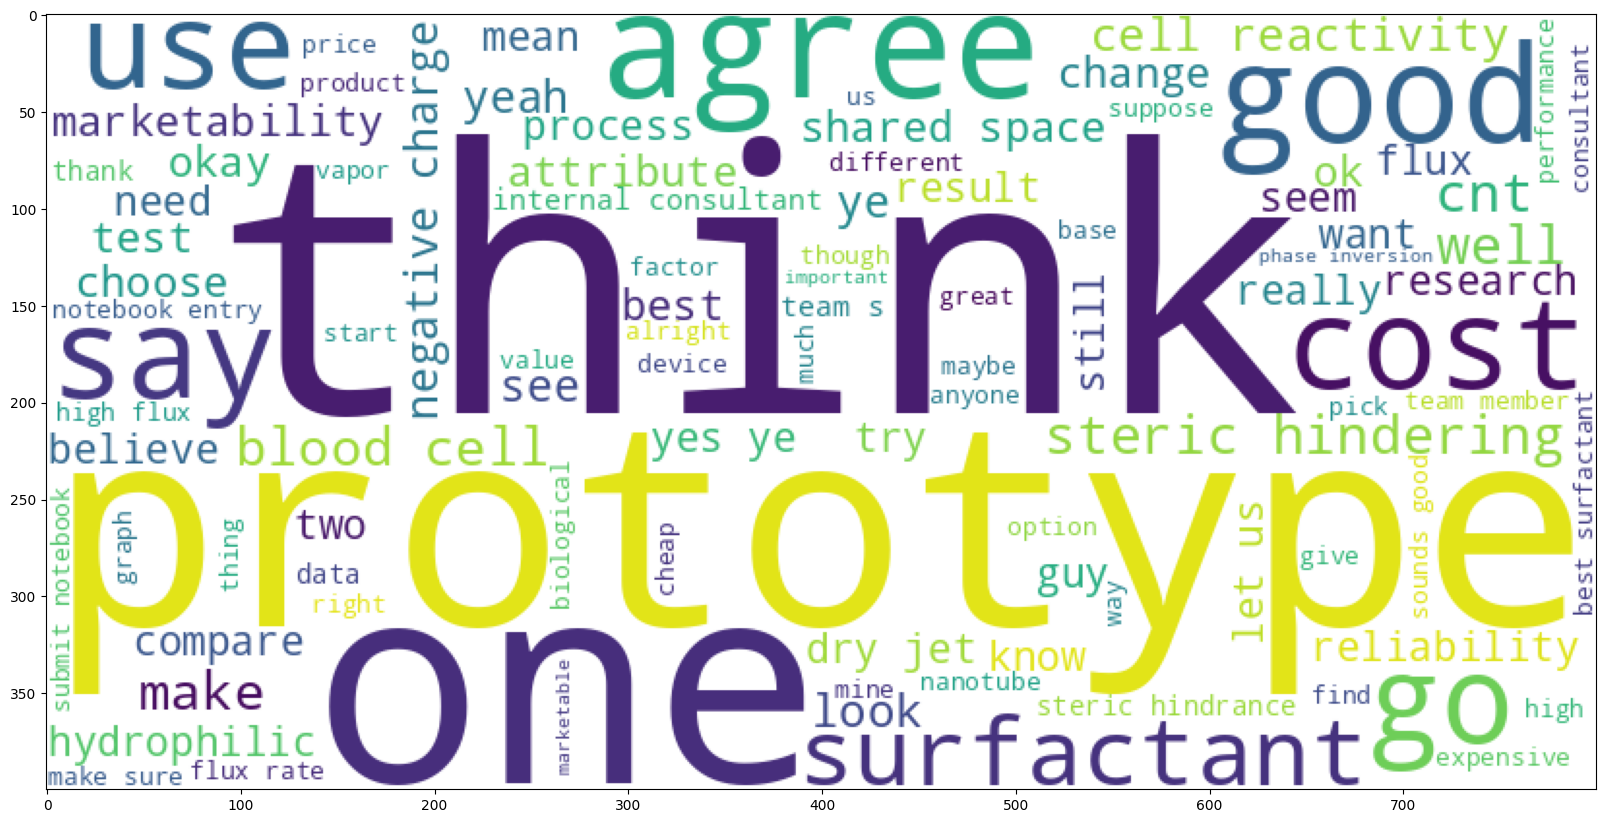

In [ ]:
data['processed_content'] = [TextAnalysis(word).execute() for word in data['content']]
a = " ".join([word for word in data['processed_content']])

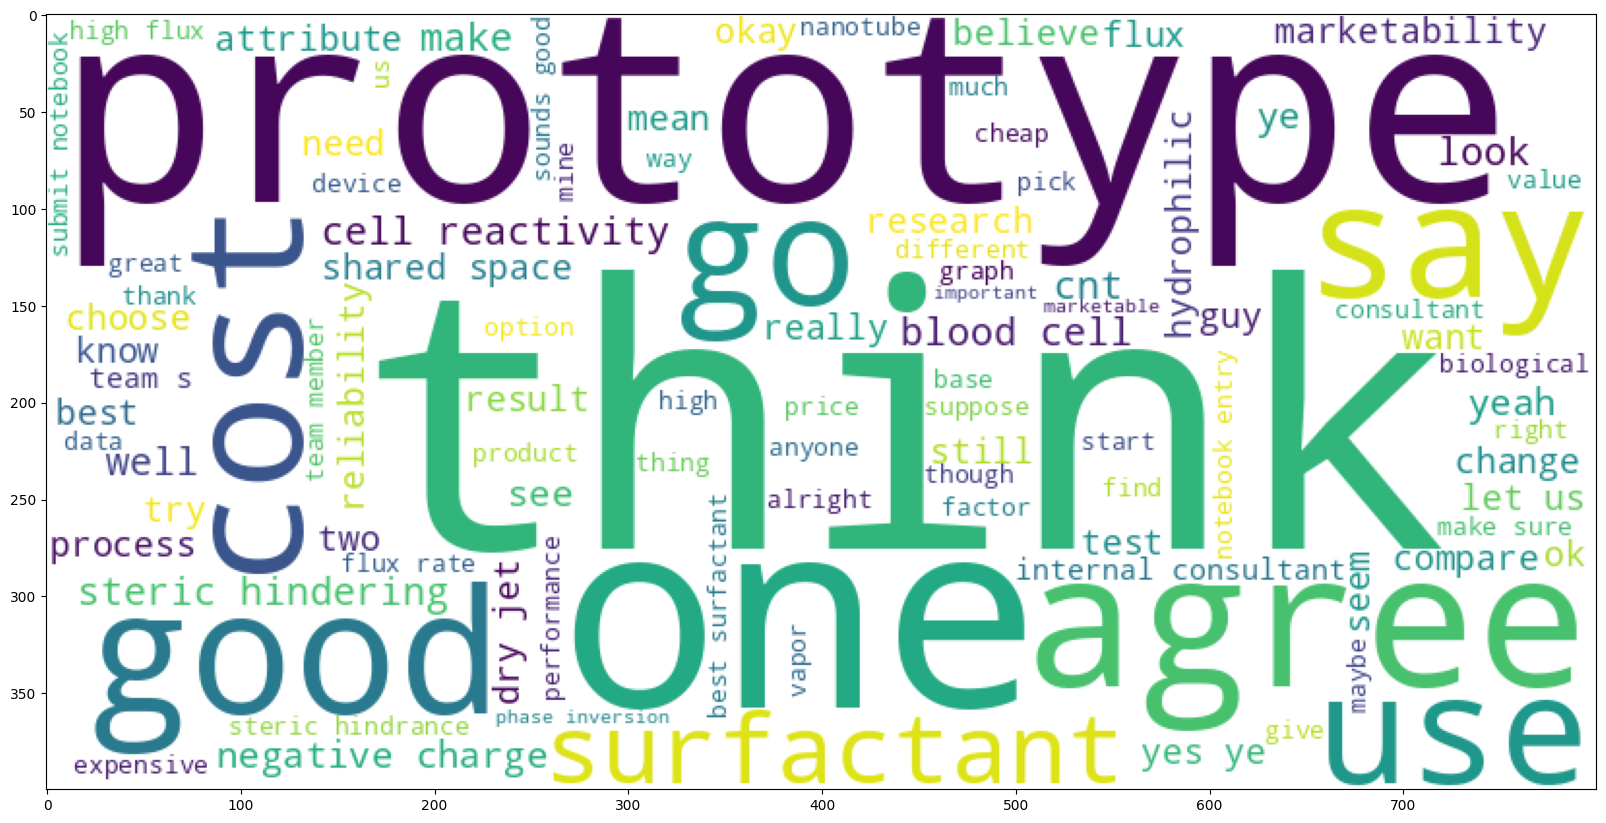

In [ ]:

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100,
    colormap="viridis"
).generate(a)

# Display the word cloud
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud)
plt.show()

In [ ]:
data.head()

,Unnamed: 0,userIDs,implementation,Line_ID,ChatGroup,content,group_id,RoleName,roomName,m_experimental_testing,m_making_design_choices,m_asking_questions,j_customer_consultants_requests,j_performance_parameters_requirements,j_communication,OutcomeScore,wordCount,processed_content
0,1,1,a,1,PRNLT,Hello team. Welcome to Nephrotex!,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,5,hello team . welcome nephrotex !
1,2,1,a,2,PRNLT,I'm Maria Williams. I'll be your design adviso...,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,11,maria williams . design advisor internship .
2,3,1,a,3,PRNLT,I'm here to help if you have any questions.,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,9,help questions .
3,4,1,a,4,PRNLT,Please introduce yourselves with the name you ...,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,1,0,0,4,51,please introduce name prefer call . workpro re...
4,5,1,a,5,PRNLT,I just want to make sure everyone has found th...,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,39,just want make sure everyone find chat interfa...


### **Word Vectorizer**

In [ ]:
vectorizer = CountVectorizer()
word_counts = vectorizer.fit_transform([" ".join(A)])

all_words = vectorizer.get_feature_names_out()
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=all_words)

#pd.concat([word_counts_df, data[['group_id', 'OutcomeScore']]], axis=1)
word_counts_df

,am,angry,be,document,extremely,first,fucking,fuiyo,guacha,guli,...,of,part,raw,sad,second,symphony,the,this,wanna,your
0,3,1,1,5,1,2,1,1,1,3,...,1,1,1,1,1,1,3,4,1,1


In [ ]:
#targeting

terms = ['angry', 'document', 'guli']

def vectorizer(terms):
    vectorizer = CountVectorizer(vocabulary=terms)
    term_counts = vectorizer.fit_transform([" ".join(A)]).toarray()
    term_counts = pd.DataFrame(term_counts, columns=terms)
    return term_counts

vector = vectorizer(terms)
vector

,angry,document,guli
0,1,5,3


In [ ]:
word_freq = word_counts_df.sum().sort_values(ascending=False).reset_index()
word_freq.columns = ['word', 'count']
word_freq

,word,count
0,document,5
1,is,5
2,this,4
3,the,3
4,guli,3
5,am,3
6,first,2
7,extremely,1
8,angry,1
9,be,1


### **Profanity**

In [ ]:
boolean_values = []

for doc in A:
    boolean_values.append(profanity.contains_profanity(doc))

df = pd.DataFrame(A)
df['contains_profanity'] = boolean_values
df

,0,contains_profanity
0,I am extremely happy,False
1,I am sad,False
2,I am angry,False
3,This is a document,False
4,This is the first document.,False
5,This document is the second document.,False
6,Is this the first document?,False
7,IT IS FUCKING RAW!,True
8,Haiya,False
9,Fuiyo,False


but that wasnt a good library cz when lemmatising it removes all 'not' out
maybe we could refer to this instead?
https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial#Quick-EDA

### Interactions between mentor and players